# Langmuir isotherm predictions improved by FoKL-GPy in benchmark comparison of temperature-dependent model

---

## Abstract

Expanding *Langmuir isotherm predictions improved by FoKL-GPy in benchmark comparison* to include temperature, the site fraction at any temperature and pressure pair may be predicted.

---

## Contents

- 1
- 2
- 3

---

## Method

From *Langmuir isotherm predictions improved by FoKL-GPy in benchmark comparison*, the following is known and will provide the Gaussian process (GP) model $\mathbf{GP}$ trained on $\Delta$ as a function of the inverse of temperature $T$ and the natural logarithim of pressure $p$. The nomenclature is taken from [[1]](#1).

$\begin{equation}\tag{1} \mathbf{GP} = \{\Delta\ |\ T^{-1},\ \ln(p)\} \end{equation}$

$\begin{equation}\tag{2} \Delta = \ln(\sigma_1) \end{equation}$

$\begin{equation}\tag{3} \sigma_1 = \frac{q}{\mu(q_{max}-q)} \end{equation}$

$\begin{equation}\tag{4} \mu = \frac{p}{\sqrt{2 \pi M R T}} \end{equation}$

$\begin{equation}\tag{5} q_{max} = b \end{equation}$

The following is also known and will provide predictions of $q$, termed $q_{cal}$, from the GP.

$\begin{equation}\tag{6} q_{cal} = \frac{\sigma_{1, cal} q_{max} \mu}{1 + \sigma_{1, cal} \mu} \end{equation}$

$\begin{equation}\tag{7} \sigma_{1, cal} = \exp(\mathbf{GP}) \end{equation}$

The values of $q_{cal}$ found with the GP may then be compared to predictions from the Toth, UNILAN, Sips, and Langmuir isotherm models. The Langmuir predictions will be calculated here, but the rest have already been found in Table 2 of [[2]](#2) which is the source of the $q(T, p)$ experimental measurements. The data from the table has been saved as *Table2.txt*.

Values of $q_s$, which will serve as $q_{max}$ for scaling $\theta_{1, cal}$ so that the GP's comparison with each model is equivalent, were taken from Tables 4-6 for Toth, UNILAN, and Sips titled *TableN_Zeolite_13X.txt* where N is 4, 5, and 6. The other model parameters are included as well for plotting visual comparisons.

---

## Implementation:

Importing modules and defining constants:

In [1]:
import os
import sys
sys.path.append(os.path.join('..', '..', '..'))  # include local path (i.e., this package)
from src.FoKL import FoKLRoutines
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate


M = 0.0440095  # molecular weight of CO2, kg/mol
R = 8.31446261815324  # universal gas constant, J/(K*mol)

Loading and parsing the data (and removing last measurement of first experiment due to induced $\sigma_1 \lt 0$ for Langmuir model linear fit):

In [2]:
data = np.loadtxt(os.path.join('data', 'Table2.txt'), skiprows=2)  # experimental measurements q(T, p)
data = np.delete(data, 23, 0) # remove last datapoint (i=23) of first experiment (i.e., T = 273.15 K) as "outlier" because it results in negative 'sigma1 = eq3(q>0, mu>0, qmax>0)' when using positive b=qmax from Langmuir model linear fit

T = data[:, 0]  # K
p = data[:, 1]  * 1e3  # Pa
q = data[:, 2]  # mol/kg

# For benchmark comparison:
percent_error = data[:, 3:6]  # %, [Toth, UNILAN, Sips]

# Model parameters (for qs=qmax and for plotting):
params = [np.loadtxt(os.path.join('data', 'Table4_Zeolite_13X.txt'), skiprows=2),  # Toth
          np.loadtxt(os.path.join('data', 'Table5_Zeolite_13X.txt'), skiprows=2),  # UNILAN
          np.loadtxt(os.path.join('data', 'Table6_Zeolite_13X.txt'), skiprows=2)]  # Sips

# For indexing:
T_const = np.where(T[:-1] != T[1:])[0]  # indices where experiment ends (i.e., where next temperature changes)
T_const = np.insert(T_const + 1, [0, len(T_const)], [0, len(T)])  # indices where experiments begin (including "next" experiment enabling 'data[T_const[i]:T_const[i + 1], :]')
n = len(T_const) - 1  # number of experiments
nd = np.array(list(T_const[i + 1] - T_const[i] for i in range(n)))  # number of datapoints in each experiment


Applying a linear fit to $\frac{p}{q}$ vs. $p$ at each constant $T$ experiment in order to obtain the Langmuir isotherm model parameters as an additional benchmark comparison, and appending to ```params```.

In [50]:
p_q = p / q

a = np.array([])  # Langmuir isotherm parameter
b = np.array([])  # Langmuir isotherm parameter, =qmax
for i in range(n):
    j = T_const[i]  # index of beginning of experiment
    k = T_const[i + 1]  # index+1 of end of experiment
    
    coeffs = np.polyfit(p[j:k], p_q[j:k], 1)  # 'coeffs=[1/b, 1/(a*b)]' in 'p/q = p/b + 1/(a*b)' linear fit

    b = np.append(b, 1 / coeffs[0])
    a = np.append(a, 1 / coeffs[1] / b[i])

def eq3_from_ref2(qexp, qcal):
    """Equation 3 from [2]. Returns average percent deviations as in Tables 4-6."""
    k = len(qexp)  # = len(qcal)
    return 100 / k * sum(np.abs((qexp[j] - qcal[j]) / qexp[j]) for j in range(k))

avec = np.repeat(a, nd)
bvec = np.repeat(b, nd)

qcal_Langmuir = avec * bvec * p / (1 + avec * p)
dq_Langmuir = np.array(list(eq3_from_ref2(q[T_const[i]:T_const[i + 1]], qcal_Langmuir[T_const[i]:T_const[i + 1]]) for i in range(n)))  # average percent deviations per experiment

params.append(np.stack([T[T_const[:-1]], b, a, dq_Langmuir], axis=1))  # 'b=qmax' placed second because 'qs=qmax' is second for other parameters
nm = len(params)  # number of isotherm models (not including FoKL) for benchmark comparison

Defining equations:

In [4]:
def eq2(sigma1):
    """Delta"""
    return np.log(sigma1)

def eq3(q, mu, qmax):
    """sigma1"""
    return q / mu / (qmax - q)

def eq4(p, M, R, T):
    """mu"""
    return p / np.sqrt(2 * np.pi * M * R * T)

def eq6(sigma1, qmax, mu):
    """qcal"""
    return sigma1 * qmax * mu / (1 + sigma1 * mu)

Calculating training set $\{\Delta\ |\ T^{-1},\ \ln(p)\}$:

In [5]:
mu = eq4(p, M, R, T)
qmaxs = list(np.repeat(param[:, 1], nd) for param in params)  # list of vectors (with repeated values for each datapoint); each vector is for different isotherm model
sigma1s = list(eq3(q, mu, qmax) for qmax in qmaxs)  # list of vectors
Deltas = list(eq2(sigma1) for sigma1 in sigma1s)  # list of vectors

inv_T = 1 / T
ln_p = np.log(p)

Training $\mathbf{GP}$ for each set of $q_{max}$ taken from isotherm model parameters (but for now, just use Langmuir model):

In [85]:
Toth_only = True  # train using qmax from Toth model only

def new_GP():
    """Initialize FoKL-GPy class object."""
    return FoKLRoutines.FoKL(kernel=1)

def train_GP(model):
    """Train FoKL-GPy model on data."""
    return model.fit([inv_T, ln_p], Deltas[i], clean=True)

GP_Toth, GP_UNILAN, GP_Sips, GP_Langmuir = new_GP(), new_GP(), new_GP(), new_GP()
GPs = [GP_Toth, GP_UNILAN, GP_Sips, GP_Langmuir]

for i in range(nm):
    if Toth_only is True:
        if i == 0:
            train_GP(GPs[i])
    else:
        train_GP(GPs[i])

/home/jacobpatrick/FoKL-GPy/docs/_dev/langmuir_isotherm/../../../src/FoKL/FoKLRoutines.py:299: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, -382.6275279140007]
[2, -590.6428200140313]
[2, -686.834509716229]
[3, -705.4683284736103]
[3, -705.4683284736103]
[4, -712.2141552528457]
[4, -712.2141552528457]
[4, -751.791854899082]
[5, -752.683419577411]
[5, -776.5885471278065]
[5, -776.5885471278065]
[6, -776.5885471278065]
[6, -782.0732659911274]
[6, -794.866040592626]
[6, -794.866040592626]
[7, -797.5142922015002]
[7, -797.5142922015002]
[7, -800.5995339035647]
[7, -832.2266468961755]
[8, -833.7093669112273]
[8, -835.343700355577]
[8, -850.1977756675437]
[8, -851.9256447737793]
[8, -856.2380863184591]
[9, -856.9381389055297]
[9, -858.3383306232777]
[9, -859.6779097949299]
[9, -855.9193168222755]
[9, -862.2077487941824]
[10, -866.9459906653177]
[10, -876.2296904315106]
[10, -885.8067918136112]
[10, -885.8067918136112]
[10, -882.8203080055886]
[10, -882.8203080055886]


Print model's interaction matrix as sanity check confirming dependence on both $(T^{-1},\ \ln(p))$:

In [86]:
for i in range(nm):
    if Toth_only is True:
        if i == 0:
            print(GPs[i].mtx)
    else:
        print(GPs[i].mtx)

[[0. 1.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [1. 2.]
 [2. 2.]
 [4. 0.]
 [3. 2.]
 [1. 4.]
 [4. 1.]
 [2. 4.]
 [5. 1.]
 [3. 4.]
 [6. 1.]
 [0. 7.]
 [7. 0.]
 [4. 4.]
 [5. 3.]
 [2. 6.]
 [6. 2.]
 [1. 7.]
 [0. 8.]
 [4. 5.]
 [6. 3.]
 [2. 7.]
 [1. 8.]
 [0. 9.]
 [5. 5.]
 [4. 6.]
 [6. 4.]
 [7. 3.]]


Calculate $q_{cal}$ predictions for comparison:

In [88]:
# For GP:
Deltas_cal = []
sigma1s_cal = []
qcals = []
for i in range(nm):
    if Toth_only is True:
        if i == 0:
            Deltas_cal.append(GPs[i].evaluate())
            sigma1s_cal.append(np.exp(Deltas_cal[i]))
            qcals.append(eq6(sigma1s_cal[i], qmaxs[i], mu))
    else:
        Deltas_cal.append([])
        sigma1s_cal.append([])
        qcals.append([])
    
# For isotherm models:

p_kPa = p * 1e-3

qs_Toth = np.repeat(params[0][:, 1], nd)  # mol/kg
b_Toth = np.repeat(params[0][:, 2], nd)  # kPa
t_Toth = np.repeat(params[0][:, 3], nd)
qcal_Toth = qs_Toth * p_kPa / (b_Toth + p_kPa ** t_Toth) ** (1 / t_Toth)  # Equation 2 of [2]

qs_UNILAN = np.repeat(params[1][:, 1], nd)  # mol/kg
c_UNILAN = np.repeat(params[1][:, 2], nd)  # kPa
s_UNILAN = np.repeat(params[1][:, 3], nd)
qcal_UNILAN = qs_UNILAN * np.log((c_UNILAN + p_kPa * np.exp(s_UNILAN)) / (c_UNILAN + p_kPa * np.exp(-s_UNILAN))) / 2 / s_UNILAN  # Equation 4 of [2]

qs_Sips = np.repeat(params[2][:, 1], nd)  # mol/kg
b_Sips = np.repeat(params[2][:, 2], nd)  # kPa
n_Sips = np.repeat(params[2][:, 3], nd)
qcal_Sips = qs_Sips * b_Sips * p_kPa ** (1 / n_Sips) / (1 + b_Sips * p_kPa ** (1 / n_Sips))  # Equation 5 of [2]

qcal_models = [qcal_Toth, qcal_UNILAN, qcal_Sips, qcal_Langmuir]  # [Toth, UNILAN, Sips, Langmuir]

# Since Delta requires qmax, and each model implies different qmax, the qcal plotted for FoKL-GPy must be chosen from each of the different qmax values used (i.e., the different GPs):
qcal_models.append(qcals[0])  # using Toth qmax values for GP because Conclusion of [2] says Toth fit Zeolite 13X best

Recreation of Figure 2 of [[2]](#2), with Lacngmuir model and GP model included:

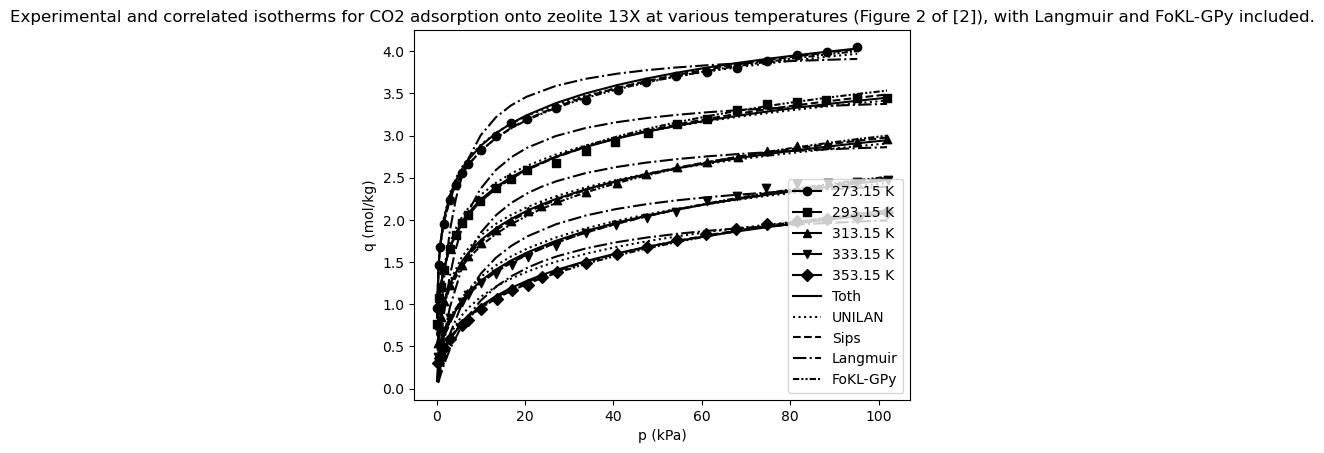

In [89]:
from matplotlib.lines import Line2D


# Define styles and legend elements:

markers = ['o', 's', '^', 'v', 'D']
labels = list(f"{np.round(T[T_const[i]], 2)} K" for i in range(n))  # temperatures for legend

model_labels = ['Toth', 'UNILAN', 'Sips', 'Langmuir', 'FoKL-GPy']
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1, 1, 1))]  # [Toth, UNLIAN, Sips] as in Figure 2 of [2], plus Langmuir and FoKL-GPy
nm_plt = len(model_labels)  # = len(linestyles); and, = nm + 1 if plotting all plus Langmuir and GP

legend_elements = list(Line2D([0], [0], marker=markers[c], color='k', label=labels[c]) for c in range(n)) + list(Line2D([0], [0], ls=linestyles[i], color='k', label=model_labels[i]) for i in range(nm_plt))

# Plot:

fig, ax = plt.subplots()
for c in range(n):  # index of temperature
    j = T_const[c]
    k = T_const[c + 1]

    plt.scatter(p_kPa[j:k], q[j:k], color='k', marker=markers[c])  # experimental measurements
    for i in range(nm_plt):  # index of model
        plt.plot(p_kPa[j:k], qcal_models[i][j:k], ls=linestyles[i], color='k')  # model; i.e., Toth, UNLIAN, Sips, Langmuir, FoKL-GPy

ax.set_xlabel('p (kPa)')
ax.set_ylabel('q (mol/kg)')
ax.set_title('Experimental and correlated isotherms for CO2 adsorption onto zeolite 13X at various temperatures (Figure 2 of [2]), with Langmuir and FoKL-GPy included.')

ax.legend(handles=legend_elements, loc='lower right')

Since the Conclusion of [[2]](#2) states the Toth model fits best of the three tried, and since the Langmuir fit is visibly inaccurate, the GP model will be compared to Toth. For this, the GP model with use $q_{max}$ values from Toth's $q_s$ values to make the comparison equivalent.

Plotting these models:

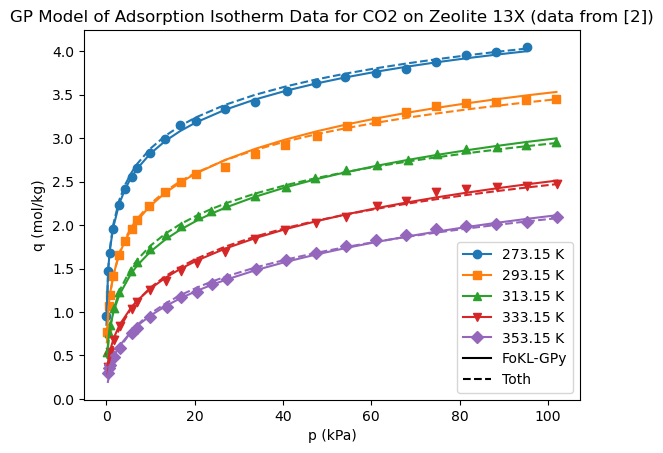

In [90]:
import matplotlib.colors as mcolors


# Define styles and legend elements:

colors = mcolors.TABLEAU_COLORS  # dictionary of all colors
colors = list(colors.values())[:n]  # first 'n' colors, one per experiment

markers = ['o', 's', '^', 'v', 'D']
labels = list(f"{np.round(T[T_const[i]], 2)} K" for i in range(n))  # temperatures for legend

legend_elements = list(Line2D([0], [0], marker=markers[c], color=colors[c], label=labels[c]) for c in range(n)) + [Line2D([0], [0], ls='-', color='k', label='FoKL-GPy'), Line2D([0], [0], ls='--', color='k', label='Toth')]

# Plot:

fig, ax = plt.subplots()
for i in range(n):
    j = T_const[i]
    k = T_const[i + 1]

    plt.scatter(p_kPa[j:k], q[j:k], color=colors[i], marker=markers[i])  # experimental measurements
    plt.plot(p_kPa[j:k], qcals[0][j:k], '-', color=colors[i])  # GP model, using Toth qs as qmax (hence qcals[0] index)
    plt.plot(p_kPa[j:k], qcal_Toth[j:k], '--', color=colors[i])  # Langmuir model

ax.set_xlabel('p (kPa)')
ax.set_ylabel('q (mol/kg)')
ax.set_title('GP Model of Adsorption Isotherm Data for CO2 on Zeolite 13X (data from [2])')
ax.legend(handles=legend_elements, loc='lower right')

Recall the GP model was applied to the original Langmuir isotherm model rather than, in the case of no GP, the improved Toth model. If attempting to modify this method for further improvement so that the GP is applied to the Toth model, consider the following.

The Langmuir model allows <br>
$q = \frac{\sigma_1 q_{max} \mu}{1+\sigma_1 \mu} \implies \Delta \equiv \ln(\sigma_1) = \frac{q}{\mu(q_{max}-q)}$ <br>
but the same is not true for the Toth model (Equation 2 of [[2]](#2)), since effectively it leads to defining $\Delta$ from one equation with two unknowns. That is, <br>
$q = \frac{q_s P}{(b+P^t)^{1/t}} \implies q = \frac{\sigma_1 q_{max} \mu}{(1+(\sigma_1 \mu)^t)^{1/t}}$. <br>

With the introduction of the additional isotherm model parameter, $t$ as defined by [[2]](#2), it is not possible to write $\sigma_1$ and thus $\Delta = \ln(\sigma_1)$ in terms of the measured $q(p)$, accepted $q_{max}$, and calculated $\mu$ values. 

Possibly using the $t$ value from the Toth fit in the calculation of $\Delta$ could improve the accuracy of the Toth model. Effectively this would be fitting a Toth model to get $t$, then training on the natural logarithm of the inferred relative life $\sigma_1$, then evaluating the Toth model for $q_{cal}$ but with $\sigma_{1, cal}$ evaluated with the GP.

Keeping in mind the single GP model contains information about all $T$, whereas the Toth model requires changing parameters $b$ and $t$. The Toth model may be rewritten across temperature as $q = \frac{q_s(T) P}{(b(T) + P^{t(T)})^{1/t(T)}}$ though this still requires training $(q_s(T), b(T), t(T))$ or fitting them in some other way. The GP requires only one fit; and, for a given $T$, does not require an entire set of measurements like the Toth fit does. That is, neither $(T, p)$ needs to be fixed in experiments modeled by the GP; but, the five temperatures shown here are required to be fixed to arrive at five Toth models.

Calculating percent error for the benchmark comparison with the Toth model:

In [91]:
# Confirm method so far and 'eq3_from_ref2' are ok:
dq_Toth_per = np.array(list(eq3_from_ref2(q[T_const[i]:T_const[i + 1]], qcal_Toth[T_const[i]:T_const[i + 1]]) for i in range(n)))  # average percent deviation, per experimemt
print('Confirming Toth model used for benchmark aligns with equivalent in [2]...\n')
print('Table 2:        ', params[0][:, -1])  # dq from Table 4 of [2]
print('Calculated here:', np.round(dq_Toth_per, 2))  # confirm results are close enough with dq from Table 4 of [2] (i.e., confirm "rounding errors" is good assumption for any discrepancy)

# If ok, calculate total dq across all T to use in benchmark:
dq_GP_per = np.array(list(eq3_from_ref2(q[T_const[i]:T_const[i + 1]], qcals[0][T_const[i]:T_const[i + 1]]) for i in range(n)))  # average percent deviation, per experimemt
dq_GP = eq3_from_ref2(q, qcals[0])  # average percent deviation, total
dq_Toth = eq3_from_ref2(q, qcal_Toth)  # average percent deviation, total
print('\nTotal percent error across T...\n')
print('Toth:', np.round(dq_Toth, 2), '%')
print('GP:  ', np.round(dq_GP, 2), '%')

Confirming Toth model used for benchmark aligns with equivalent in [2]...

Table 2:         [1.85 1.93 2.05 4.35 5.09]
Calculated here: [1.88 1.91 2.01 4.39 5.18]

Total percent error across T...

Toth: 3.07 %
GP:   1.47 %


Converting to Pyomo:

In [98]:
from src.FoKL.fokl_to_pyomo import fokl_to_pyomo

# FAILS TO MAKE inv_T_normalized with [True, True]
m = fokl_to_pyomo(GPs[0], ['inv_T', 'ln_p'], 'Delta', 3, truescale=[True, True])  # NOTE FOR DEV ... truescale=True failed to automatically convert

m.pprint()

3 Set Declarations
    GP0_j : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}
    GP0_k : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   32 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
    GP0_scenarios : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}

4 Var Declarations
    Delta : Size=3, Index=GP0_scenarios
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :  None :  None : False :  True :  Reals
          1 :  None :  None :  None : False :  True :  Reals
          2 :  None :  None :  None : False :  True :  Reals
    GP0_b : Size=96, Index=GP0_scenarios*GP0_k
        Key     : Lower : Value                  : Upper : Fixed : Stale : Dom

## References

[1] Langmuir 1918

[2]
-  https://pubs.acs.org/doi/10.1021/je020050e
    - gold mine of data -- Tables 2-3
